# the packages

In [2]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# beyasian modeling
import bambi as bmb

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [3]:
# set the figure theme
sns.set_theme(style="whitegrid")

# simulation1(v ~ coherence,t ~ attention)

In [ ]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 100

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.05
v_sig2 = 0.05
# intercept and slope of t
t_int = 0.3
t_pri = 0.2
t_sig1 = 0.02
t_sig2 = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of z
z_int = 0.5
z_sig = 0.1


## the hierarchical struction

In [4]:
# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig1,[n_subjects,2])
t_pri_subj = np.random.normal(t_pri,t_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
params = pd.DataFrame()
for i in range(n_subjects):
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    t_yes = t_int_subj[i] - t_pri_subj[i]
    t_no = t_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter z
    z = z_int_subj[i]
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = 1   # face
    data_b['stimulus'] = 0

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = i

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    # combine data
    df = df.append(data)
    

    # create dataframe
    params_a = pd.DataFrame(params_a).T.reset_index().rename(columns={'index': 'condition'})
    params_b = pd.DataFrame(params_b).T.reset_index().rename(columns={'index': 'condition'})
    
    # add stmilulus
    params_a['stimulus'] = 1
    params_b['stimulus'] = 0

    # combine two stimulus
    param = params_a.append(params_b,ignore_index=True)
    
    # add column coherence
    param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
    param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0
    
    # add column spatial priotiziation
    param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
    param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0
    
    # add subject
    param['subj_idx'] = i

    # combine params
    params = params.append(param)

## the non-hierarchical struction

In [159]:
# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':v_int+v+coh, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':v_int+v+coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':v_int, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':v_int+v+coh, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':v_int+v+coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':v_int, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# data
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

# params
# create dataframe
levels = ['level1','level2','level3','level4']

paramsa = pd.DataFrame()
paramsb = pd.DataFrame()

# combine the params for each level
for level in levels:
    parama = pd.DataFrame(params_a[level]).reset_index().rename(columns={'index': 'subj_idx'})
    parama['condition'] = level
    paramsa = paramsa.append(parama,ignore_index=True)
    
    paramb = pd.DataFrame(params_b[level]).reset_index().rename(columns={'index': 'subj_idx'})
    paramb['condition'] = level
    paramsb = paramsb.append(paramb,ignore_index=True)

# add stmilulus
paramsa['stimulus'] = 1
paramsb['stimulus'] = 0
# combine two stimulus
param = paramsa.append(paramsb,ignore_index=True)

# add column coherence
param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0

## the visualization 

In [160]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.365447,1.0,0,level1,1,1.0,1.0
1,0.165447,1.0,0,level1,1,1.0,1.0
2,0.145447,1.0,0,level1,1,1.0,1.0
3,0.274447,1.0,0,level1,1,1.0,1.0
4,0.384447,1.0,0,level1,1,1.0,1.0
...,...,...,...,...,...,...,...
475,0.797968,0.0,14,level4,0,0.0,0.0
476,0.559968,1.0,14,level4,0,0.0,0.0
477,0.813968,0.0,14,level4,0,0.0,0.0
478,0.676968,1.0,14,level4,0,0.0,0.0


In [161]:
data

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.230767,0.0,0,level1,1.0,1.0,1.0
1,0.180435,0.0,0,level1,1.0,1.0,1.0
2,0.426557,1.0,0,level1,1.0,1.0,1.0
3,0.507459,1.0,0,level1,1.0,1.0,1.0
4,0.538269,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
7195,0.664044,1.0,14,level4,0.0,0.0,0.0
7196,0.503046,1.0,14,level4,0.0,0.0,0.0
7197,0.757299,1.0,14,level4,0.0,0.0,0.0
7198,0.634963,1.0,14,level4,0.0,0.0,0.0


In [162]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.608251,1.323856,0.044447,0.550270,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.608251,1.323856,0.290589,0.550270,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,1.045628,1.323856,0.044447,0.550270,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,1.045628,1.323856,0.290589,0.550270,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.570092,1.435452,0.082406,0.393018,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.971737,1.364735,0.272185,0.412115,0.0,0.0,0.0,1,0.0,0.0,14
4,level1,1.492599,1.387810,0.071548,0.639914,0.0,0.0,0.0,0,1.0,1.0,14
5,level2,1.492599,1.387810,0.277968,0.639914,0.0,0.0,0.0,0,1.0,0.0,14
6,level3,0.990655,1.387810,0.071548,0.639914,0.0,0.0,0.0,0,0.0,1.0,14


In [163]:
param

,subj_idx,v,a,t,z,sv,sz,st,condition,stimulus,coherence,attention
0,0,1.391437,1.499735,0.128298,0.349371,0.165144,0.126594,0.149139,level1,1,1.0,1.0
1,1,1.436110,1.553409,0.047009,0.450903,0.097681,0.003594,0.085010,level1,1,1.0,1.0
2,2,1.430742,1.394253,0.112652,0.363999,0.077400,0.132027,0.091146,level1,1,1.0,1.0
3,3,1.639307,1.368330,0.073442,0.482210,0.053880,0.026296,0.064204,level1,1,1.0,1.0
4,4,1.468736,1.474389,0.130291,0.295338,0.091030,0.067167,0.051952,level1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
115,10,0.993296,1.416429,0.356254,0.577469,0.064336,0.024242,0.086807,level4,0,0.0,0.0
116,11,1.059553,1.355823,0.359618,0.329687,0.033847,0.105858,0.068398,level4,0,0.0,0.0
117,12,1.142951,1.517580,0.461277,0.488493,0.144795,0.270778,0.149861,level4,0,0.0,0.0
118,13,0.982749,1.284135,0.233906,0.509156,0.229758,0.014370,0.053804,level4,0,0.0,0.0


### the description subj level

In [164]:
df.rt.describe()

count    7200.000000
mean        0.559996
std         0.325153
min         0.069447
25%         0.346166
50%         0.484250
75%         0.690056
max         3.003491
Name: rt, dtype: float64

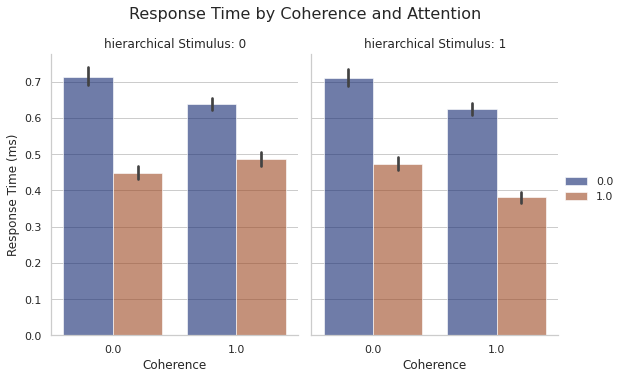

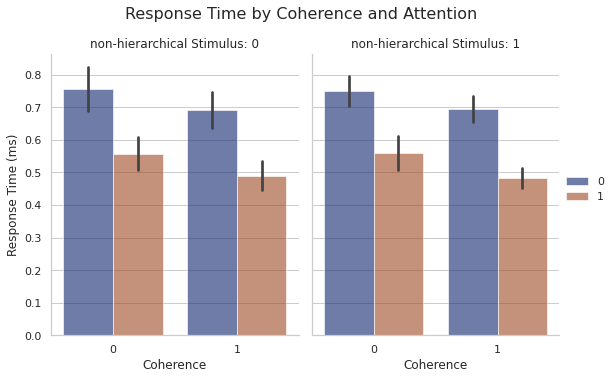

In [165]:
# hierarchical
# get the mean of accurate RTs
df_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
df_rt_sum['stimulus'] = df_rt_sum['stimulus'].astype('int64')
df_rt_sum['coherence'] = df_rt_sum['coherence'].astype('int64')
df_rt_sum['attention'] = df_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = df,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

# non-hierarchical
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

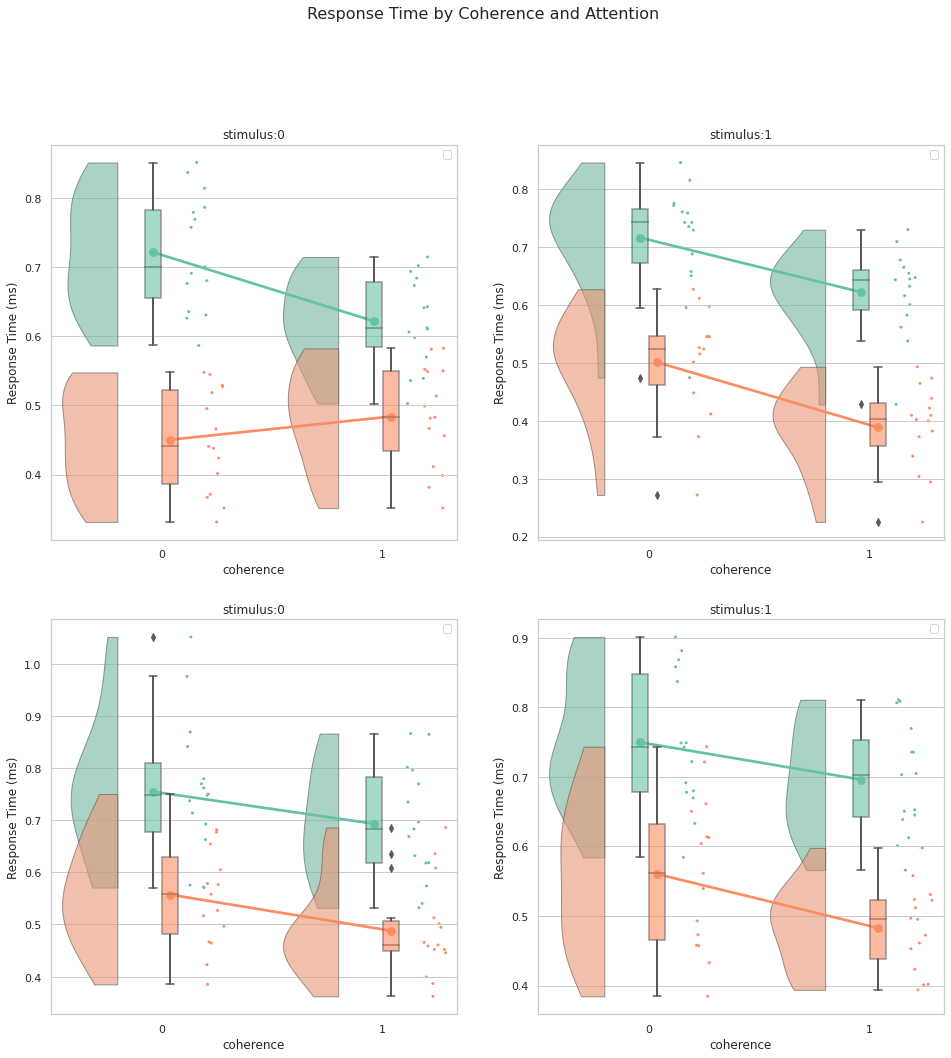

In [166]:
f, ax = plt.subplots(2,2,figsize=(16, 16))
# non-hierarchical
# the right figure
ax[0,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,0].legend('')
ax[0,0].set_title('stimulus:0')
ax[0,0].set_ylabel('Response Time (ms)')
# the right figure
ax[0,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,1].legend('')
ax[0,1].set_title('stimulus:1')
ax[0,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)
# non-hierarchical
ax[1,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,0].legend('')
ax[1,0].set_title('stimulus:0')
ax[1,0].set_ylabel('Response Time (ms)')
# the right figure
ax[1,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,1].legend('')
ax[1,1].set_title('stimulus:1')
ax[1,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [167]:
# ANOVA for hierarchical
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                     399.1302 1.0000 14.0000 0.0000
attention                    3341.4233 1.0000 14.0000 0.0000
stimulus                        1.2814 1.0000 14.0000 0.2766
coherence:attention          2596.8967 1.0000 14.0000 0.0000
coherence:stimulus             95.2850 1.0000 14.0000 0.0000
attention:stimulus             35.3624 1.0000 14.0000 0.0000
coherence:attention:stimulus 2140.2961 1.0000 14.0000 0.0000

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    216.0241 1.0000 14.0000 0.0000
attention                     36.3896 1.0000 14.0000 0.0000
stimulus                       0.2571 1.0000 14.0000 0.6200
coherence:attention           46.0403 1.0000 14.0000 0.0000
coherence:stimulus      

In [168]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                     73.7997 1.0000 14.0000 0.0000
attention                    806.1430 1.0000 14.0000 0.0000
stimulus                       0.0334 1.0000 14.0000 0.8577
coherence:attention            0.2719 1.0000 14.0000 0.6102
coherence:stimulus             0.0010 1.0000 14.0000 0.9757
attention:stimulus             0.1278 1.0000 14.0000 0.7260
coherence:attention:stimulus   0.4242 1.0000 14.0000 0.5254

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    71.5374 1.0000 14.0000 0.0000
attention                     0.9121 1.0000 14.0000 0.3558
stimulus                      1.6152 1.0000 14.0000 0.2245
coherence:attention           0.0950 1.0000 14.0000 0.7624
coherence:stimulus            0.4489 1.0

### rt distribution

In [169]:
# flip the rt of response 0 to negative
df.loc[df['response']==0,'rt'] = -df.loc[df['response']==0,'rt']

In [170]:
# flip the rt of response 0 to negative
data.loc[data['response']==0,'rt'] = -data.loc[data['response']==0,'rt']

Text(0, 0.5, 'counts')

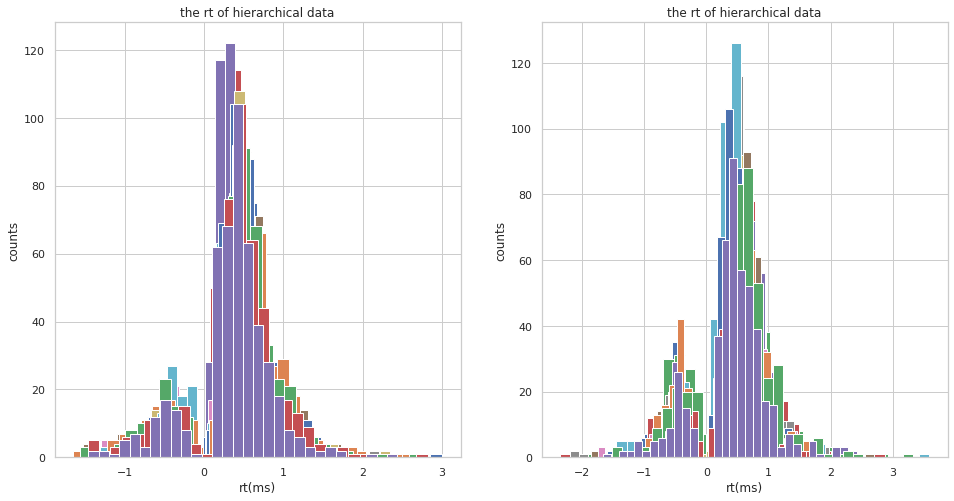

In [171]:
# create the figure 
f, ax = plt.subplots(1,2,figsize=(16, 8))

# the rt of hierarchical data
df.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[0])
# the labels of hierarchical data
ax[0].set_title('the rt of hierarchical data')
ax[0].set_xlabel('rt(ms)')
ax[0].set_ylabel('counts')

# the rt of non-hierarchical data
data.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[1])
# the labels of hierarchical data
ax[1].set_title('the rt of hierarchical data')
ax[1].set_xlabel('rt(ms)')
ax[1].set_ylabel('counts')

### rt distribution of different conditions

Text(0, 0.5, 'counts')

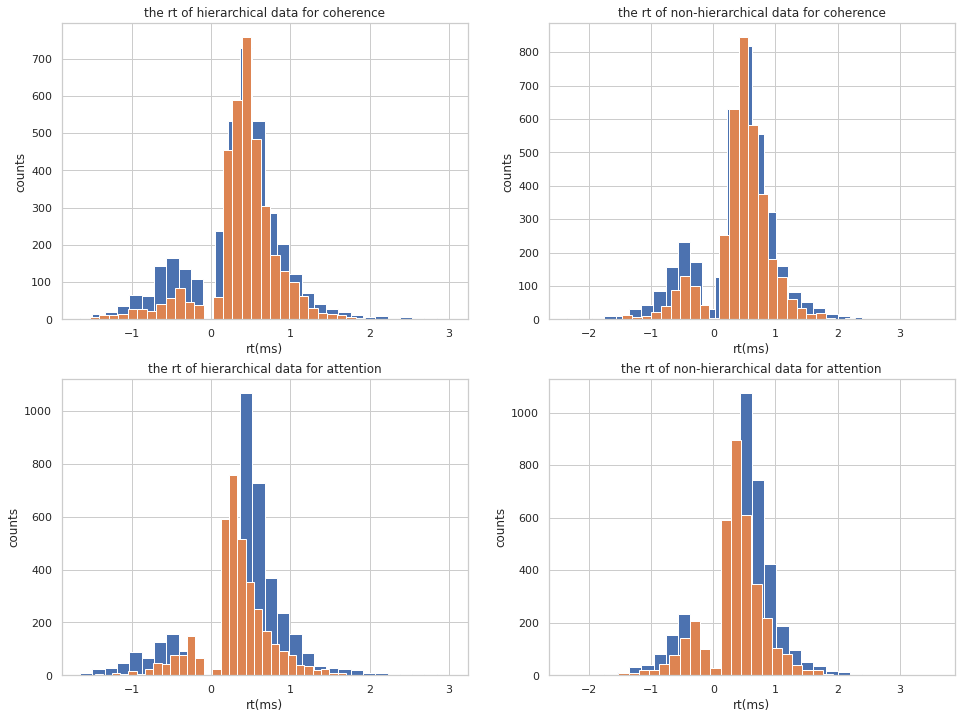

In [172]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
df.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of hierarchical data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')

# the rt of non-hierarchical data for coherence
data.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of non-hierarchical data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')

# the rt of hierarchical data for attention
df.groupby(['attention']).rt.hist(bins=30,ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of hierarchical data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')

# the rt of non-hierarchical data for attention
data.groupby(['attention']).rt.hist(bins=30,ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('the rt of non-hierarchical data for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')

### the parameter distributions

Text(0, 0.5, 'density')

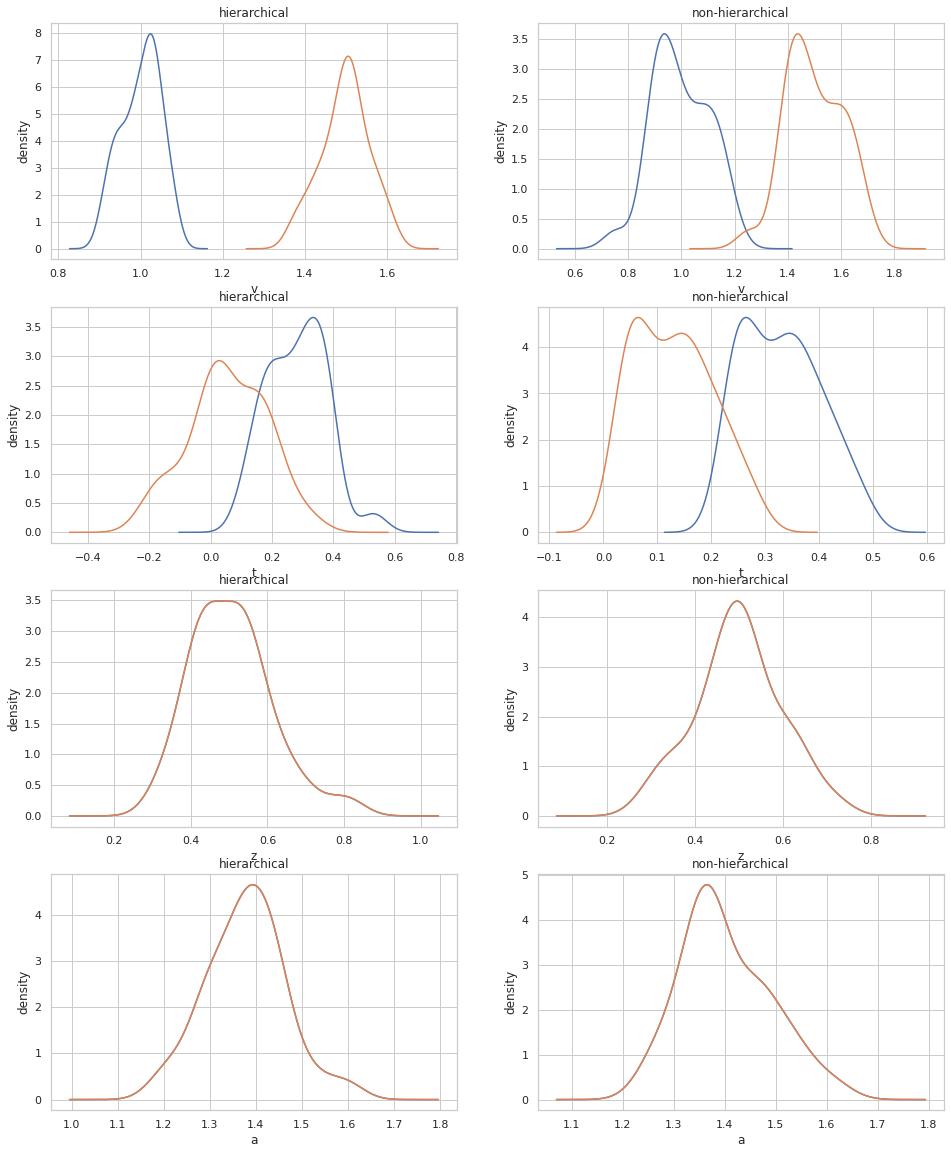

In [157]:
# create the figure 
f, ax = plt.subplots(4,2,figsize=(16, 20))

# the rt of hierarchical data for coherence
# v
params.groupby(['coherence']).v.plot.kde(ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('hierarchical')
ax[0,0].set_xlabel('v')
ax[0,0].set_ylabel('density')

# t
params.groupby(['attention']).t.plot.kde(ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('hierarchical')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('density')

# z
params.groupby(['attention']).z.plot.kde(ax=ax[2,0])
# the labels of hierarchical data
ax[2,0].set_title('hierarchical')
ax[2,0].set_xlabel('z')
ax[2,0].set_ylabel('density')

# a
params.groupby(['attention']).a.plot.kde(ax=ax[3,0])
# the labels of hierarchical data
ax[3,0].set_title('hierarchical')
ax[3,0].set_xlabel('a')
ax[3,0].set_ylabel('density')

# the rt of non-hierarchical data for coherence
# v
param.groupby(['coherence']).v.plot.kde(ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('non-hierarchical')
ax[0,1].set_xlabel('v')
ax[0,1].set_ylabel('density')

# t
param.groupby(['attention']).t.plot.kde(ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('non-hierarchical')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('density')

# z
param.groupby(['attention']).z.plot.kde(ax=ax[2,1])
# the labels of hierarchical data
ax[2,1].set_title('non-hierarchical')
ax[2,1].set_xlabel('z')
ax[2,1].set_ylabel('density')

# a
param.groupby(['attention']).a.plot.kde(ax=ax[3,1])
# the labels of hierarchical data
ax[3,1].set_title('non-hierarchical')
ax[3,1].set_xlabel('a')
ax[3,1].set_ylabel('density')

## linear regression

In [246]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.461653,1.451231,0.101899,0.588400,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.461653,1.451231,0.325471,0.588400,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,1.009429,1.451231,0.101899,0.588400,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,1.009429,1.451231,0.325471,0.588400,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.518718,1.475201,0.131767,0.425311,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.986272,1.399982,0.300810,0.560642,0.0,0.0,0.0,1,0.0,0.0,19
4,level1,1.501310,1.442714,0.120721,0.695155,0.0,0.0,0.0,0,1.0,1.0,19
5,level2,1.501310,1.442714,0.301610,0.695155,0.0,0.0,0.0,0,1.0,0.0,19
6,level3,1.010833,1.442714,0.120721,0.695155,0.0,0.0,0.0,0,0.0,1.0,19


### model for v:

$v_{j}=\beta_{0,j} + \beta_{1,j}*C(coherence)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [5]:
# contrust model
m1 = bmb.Model("v ~ 1 + coherence + (1 + coherence|subj_idx)", data=params)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, coherence|subj_idx_offset, coherence|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, coherence, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 18 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
m1

Formula: v ~ 1 + coherence + (1 + coherence|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.2566, sigma: 0.9013)
    coherence ~ Normal(mu: 0.0, sigma: 1.2746)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.9013))
    coherence|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2746))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2549)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'coherence'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>],
      dtype=object)

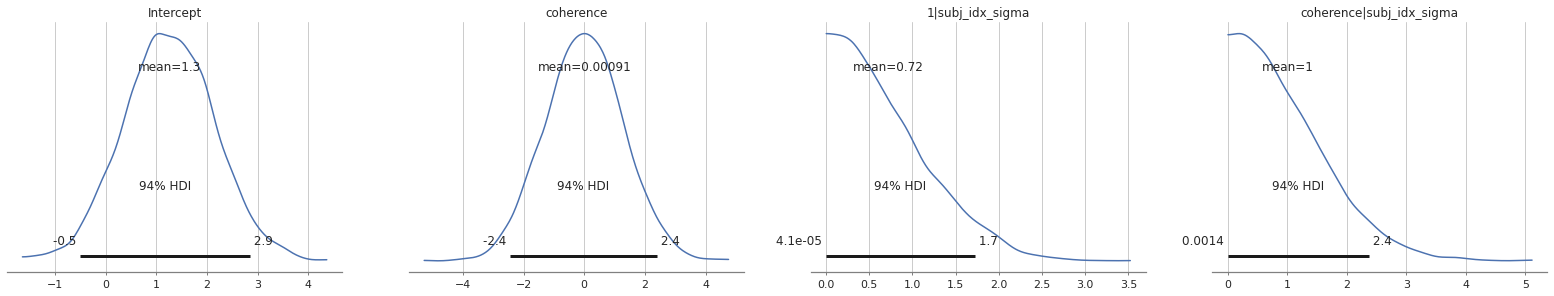

In [7]:
m1.plot_priors(var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'coherence'}>,
        <AxesSubplot:title={'center':'coherence'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>]],
      dtype=object)

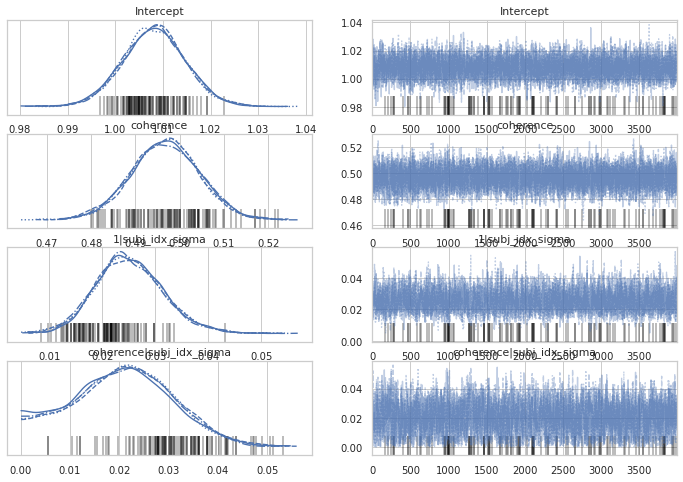

In [8]:
# Plot posteriors
az.plot_trace(
    res1,
    var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'],
    compact=True,
)

In [9]:
az.summary(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma','v_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.008,0.007,0.996,1.020,0.0,0.0,6628.0,8947.0,1.0
coherence,0.497,0.008,0.482,0.511,0.0,0.0,6370.0,5574.0,1.0
1|subj_idx_sigma,0.025,0.006,0.013,0.037,0.0,0.0,2489.0,2681.0,1.0
coherence|subj_idx_sigma,0.021,0.010,0.000,0.036,0.0,0.0,2287.0,4085.0,1.0
v_sigma,0.050,0.003,0.046,0.055,0.0,0.0,8010.0,6860.0,1.0


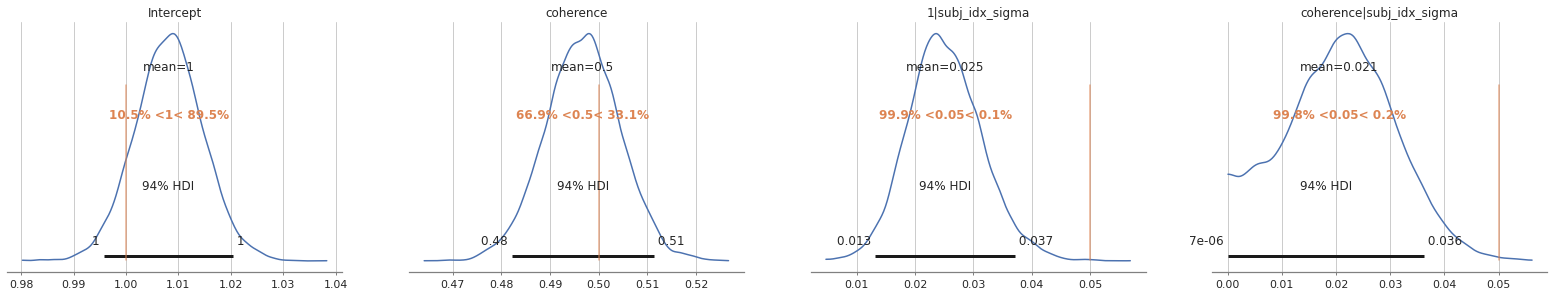

In [10]:
az.plot_posterior(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'], ref_val=[1,0.5,0.05,0.05]);


### model for t:

$t_{j}=\beta_{0,j} + \beta_{1,j}*C(attention)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [11]:
# contrust model
m2 = bmb.Model("t ~ 1 + attention + (1 + attention|subj_idx)", data=params)
# model fit
res2 = m2.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_sigma, attention|subj_idx_offset, attention|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, attention, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 16 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
m2

Formula: t ~ 1 + attention + (1 + attention|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.1976, sigma: 0.3634)
    attention ~ Normal(mu: 0.0, sigma: 0.514)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.3634))
    attention|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.514))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.1028)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'attention'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>],
      dtype=object)

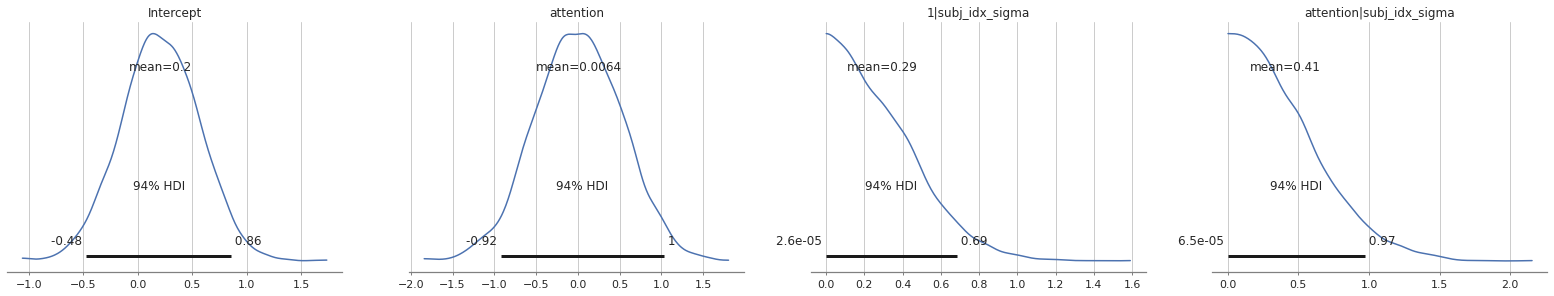

In [13]:
m2.plot_priors(var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'attention'}>,
        <AxesSubplot:title={'center':'attention'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'attention|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>]],
      dtype=object)

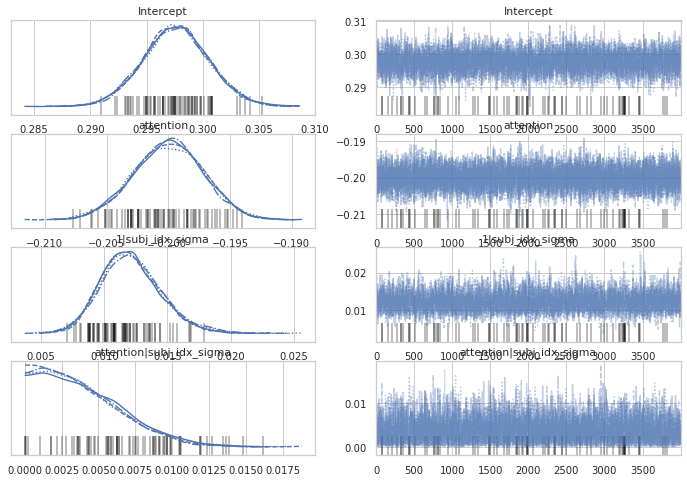

In [14]:
# Plot posteriors
az.plot_trace(
    res2,
    var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],
    compact=True,
)

In [15]:
az.summary(res2, var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.298,0.003,0.292,0.303,0.0,0.0,5395.0,7848.0,1.0
attention,-0.200,0.003,-0.205,-0.195,0.0,0.0,9448.0,7519.0,1.0
1|subj_idx_sigma,0.012,0.002,0.008,0.017,0.0,0.0,3414.0,5143.0,1.0
attention|subj_idx_sigma,0.004,0.003,0.000,0.009,0.0,0.0,3153.0,4151.0,1.0


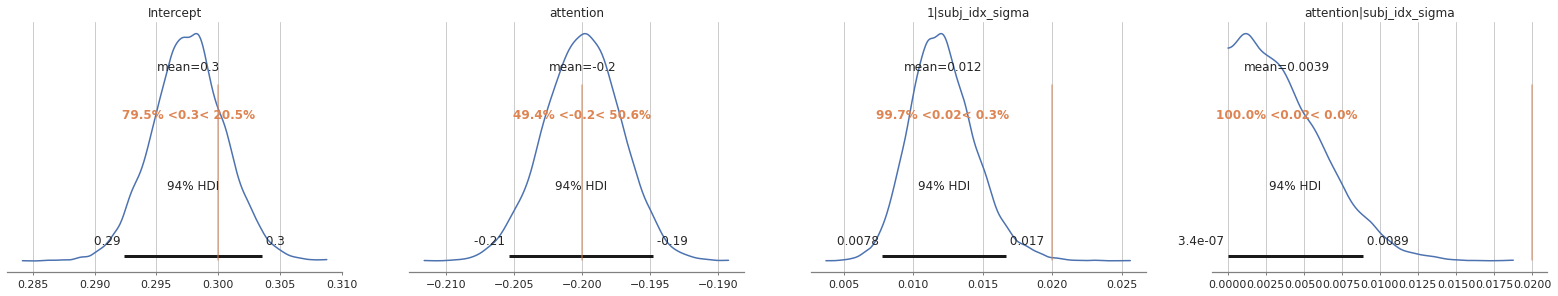

In [16]:
az.plot_posterior(res2,  var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'], ref_val=[0.3,-0.2,0.02,0.02]);


# simulation2(v ~ coherence, z ~ attention)

In [48]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 100

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.05
v_sig2 = 0.05
# intercept and slope of z
z_int = 0.5
z_pri = 0.2
z_sig1 = 0.02
z_sig2 = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of t
t_int = 0.2
t_sig = 0.05

## the hierarchical struction

In [80]:
# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig1,[n_subjects,2])
z_pri_subj = np.random.normal(z_pri,z_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
for i in range(n_subjects):
    
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    z_yes = z_int_subj[i] + z_pri_subj[i]
    z_no = z_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter t
    t = t_int_subj[i]
    
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # data
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

    # params
    # create dataframe
    params_a = pd.DataFrame(params_a).T.reset_index().rename(columns={'index': 'condition'})
    params_b = pd.DataFrame(params_b).T.reset_index().rename(columns={'index': 'condition'})
    
    # add stmilulus
    params_a['stimulus'] = 1
    params_b['stimulus'] = 0

    # combine two stimulus
    param = params_a.append(params_b,ignore_index=True)
    
    # add column coherence
    param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
    param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0
    
    # add column spatial priotiziation
    param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
    param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0
    
    # add subject
    param['subj_idx'] = i

    # combine params
    params = params.append(param)

## the non-hierarchical struction

In [49]:
# set the random seed
np.random.seed(123)

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

# params
# create dataframe
levels = ['level1','level2','level3','level4']

paramsa = pd.DataFrame()
paramsb = pd.DataFrame()

# combine the params for each level
for level in levels:
    parama = pd.DataFrame(params_a[level]).reset_index().rename(columns={'index': 'subj_idx'})
    parama['condition'] = level
    paramsa = paramsa.append(parama,ignore_index=True)
    
    paramb = pd.DataFrame(params_b[level]).reset_index().rename(columns={'index': 'subj_idx'})
    paramb['condition'] = level
    paramsb = paramsb.append(paramb,ignore_index=True)

# add stmilulus
paramsa['stimulus'] = 1
paramsb['stimulus'] = 0
# combine two stimulus
param = paramsa.append(paramsb,ignore_index=True)

# add column coherence
param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0

## the visualization 

In [50]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.477274,1.0,0,level1,1.0,1.0,1.0
1,0.311274,1.0,0,level1,1.0,1.0,1.0
2,0.297274,1.0,0,level1,1.0,1.0,1.0
3,0.396274,1.0,0,level1,1.0,1.0,1.0
4,0.495274,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
795,0.512738,0.0,29,level4,0.0,0.0,0.0
796,0.498738,1.0,29,level4,0.0,0.0,0.0
797,0.383738,1.0,29,level4,0.0,0.0,0.0
798,0.406738,1.0,29,level4,0.0,0.0,0.0


In [51]:
data

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.345013,1.0,0,level1,1.0,1.0,1.0
1,0.333509,1.0,0,level1,1.0,1.0,1.0
2,0.435129,1.0,0,level1,1.0,1.0,1.0
3,0.582129,1.0,0,level1,1.0,1.0,1.0
4,0.644750,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
23995,0.626126,1.0,29,level4,0.0,0.0,0.0
23996,0.510086,1.0,29,level4,0.0,0.0,0.0
23997,1.332681,1.0,29,level4,0.0,0.0,0.0
23998,0.364289,1.0,29,level4,0.0,0.0,0.0


In [52]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.409535,1.190925,0.081279,0.366503,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.409535,1.190925,0.319731,0.366503,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,0.986282,1.190925,0.081279,0.366503,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,0.986282,1.190925,0.319731,0.366503,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.467499,1.372812,0.113057,0.453646,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.923474,1.364198,0.179018,0.521048,0.0,0.0,0.0,1,0.0,0.0,29
4,level1,1.608800,1.377197,0.231738,0.704558,0.0,0.0,0.0,0,1.0,1.0,29
5,level2,1.608800,1.377197,0.231738,0.521048,0.0,0.0,0.0,0,1.0,0.0,29
6,level3,1.053723,1.377197,0.231738,0.704558,0.0,0.0,0.0,0,0.0,1.0,29


In [53]:
param

,subj_idx,v,a,t,z,sv,sz,st,condition,stimulus,coherence,attention
0,0,1.391437,1.499735,0.228298,0.549371,0.165144,0.126594,0.149139,level1,1,1.0,1.0
1,1,1.436110,1.328251,0.102744,0.656033,0.108822,0.088777,0.021459,level1,1,1.0,1.0
2,2,1.459784,1.415632,0.160677,0.725108,0.154792,0.117540,0.017293,level1,1,1.0,1.0
3,3,1.340556,1.316089,0.219245,0.781033,0.116799,0.049573,0.040863,level1,1,1.0,1.0
4,4,1.401180,1.474330,0.128884,0.757748,0.094922,0.088477,0.083453,level1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,25,0.980489,1.480073,0.236111,0.549541,0.007183,0.156149,0.003886,level4,0,0.0,0.0
236,26,0.931164,1.560618,0.065971,0.600477,0.051703,0.016966,0.059456,level4,0,0.0,0.0
237,27,0.939921,1.454564,0.322443,0.522298,0.049039,0.049716,0.172372,level4,0,0.0,0.0
238,28,0.984148,1.511818,0.083433,0.299815,0.092479,0.160644,0.136113,level4,0,0.0,0.0


### the description subj level

In [54]:
df.rt.describe()

count    24000.000000
mean         0.529824
std          0.317793
min          0.053647
25%          0.312913
50%          0.433860
75%          0.645645
max          2.365211
Name: rt, dtype: float64

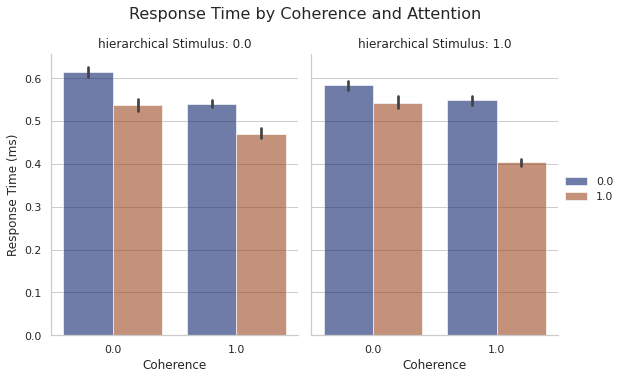

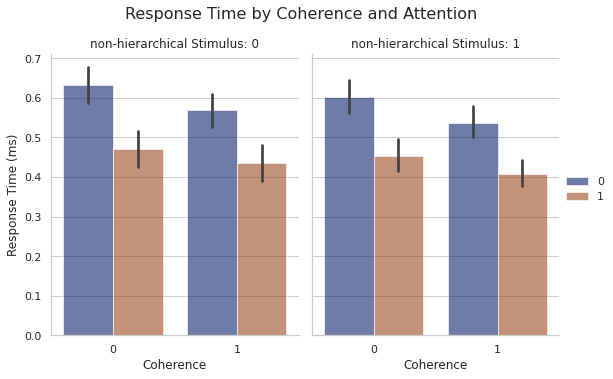

In [55]:
# hierarchical
# get the mean of accurate RTs
df_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
df_rt_sum['stimulus'] = df_rt_sum['stimulus'].astype('int64')
df_rt_sum['coherence'] = df_rt_sum['coherence'].astype('int64')
df_rt_sum['attention'] = df_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = df,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

# non-hierarchical
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

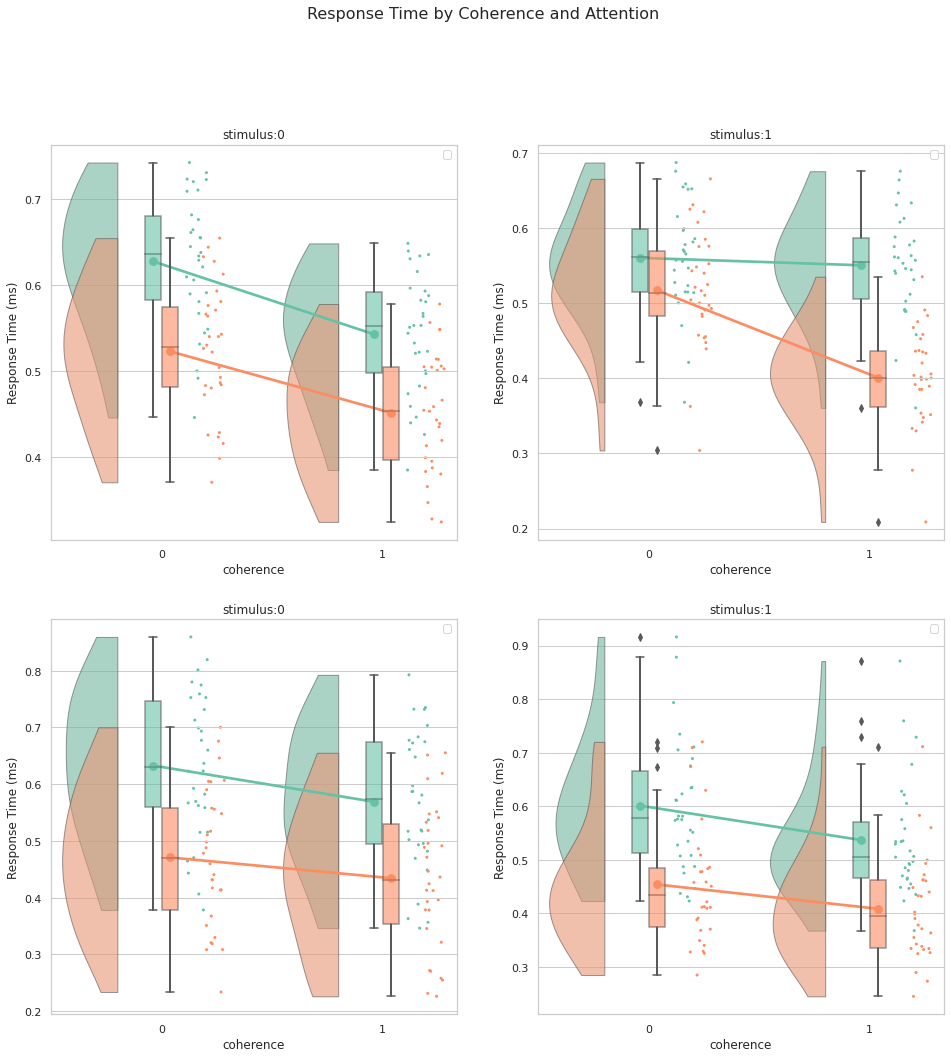

In [56]:
f, ax = plt.subplots(2,2,figsize=(16, 16))
# non-hierarchical
# the right figure
ax[0,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,0].legend('')
ax[0,0].set_title('stimulus:0')
ax[0,0].set_ylabel('Response Time (ms)')
# the right figure
ax[0,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,1].legend('')
ax[0,1].set_title('stimulus:1')
ax[0,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)
# non-hierarchical
ax[1,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,0].legend('')
ax[1,0].set_title('stimulus:0')
ax[1,0].set_ylabel('Response Time (ms)')
# the right figure
ax[1,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,1].legend('')
ax[1,1].set_title('stimulus:1')
ax[1,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [167]:
# ANOVA for hierarchical
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                     399.1302 1.0000 14.0000 0.0000
attention                    3341.4233 1.0000 14.0000 0.0000
stimulus                        1.2814 1.0000 14.0000 0.2766
coherence:attention          2596.8967 1.0000 14.0000 0.0000
coherence:stimulus             95.2850 1.0000 14.0000 0.0000
attention:stimulus             35.3624 1.0000 14.0000 0.0000
coherence:attention:stimulus 2140.2961 1.0000 14.0000 0.0000

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    216.0241 1.0000 14.0000 0.0000
attention                     36.3896 1.0000 14.0000 0.0000
stimulus                       0.2571 1.0000 14.0000 0.6200
coherence:attention           46.0403 1.0000 14.0000 0.0000
coherence:stimulus      

In [168]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                     73.7997 1.0000 14.0000 0.0000
attention                    806.1430 1.0000 14.0000 0.0000
stimulus                       0.0334 1.0000 14.0000 0.8577
coherence:attention            0.2719 1.0000 14.0000 0.6102
coherence:stimulus             0.0010 1.0000 14.0000 0.9757
attention:stimulus             0.1278 1.0000 14.0000 0.7260
coherence:attention:stimulus   0.4242 1.0000 14.0000 0.5254

                          Anova
                             F Value Num DF  Den DF Pr > F
----------------------------------------------------------
coherence                    71.5374 1.0000 14.0000 0.0000
attention                     0.9121 1.0000 14.0000 0.3558
stimulus                      1.6152 1.0000 14.0000 0.2245
coherence:attention           0.0950 1.0000 14.0000 0.7624
coherence:stimulus            0.4489 1.0

### rt distribution

In [57]:
# flip the rt of response 0 to negative
df.loc[df['response']==0,'rt'] = -df.loc[df['response']==0,'rt']

In [58]:
# flip the rt of response 0 to negative
data.loc[data['response']==0,'rt'] = -data.loc[data['response']==0,'rt']

Text(0, 0.5, 'counts')

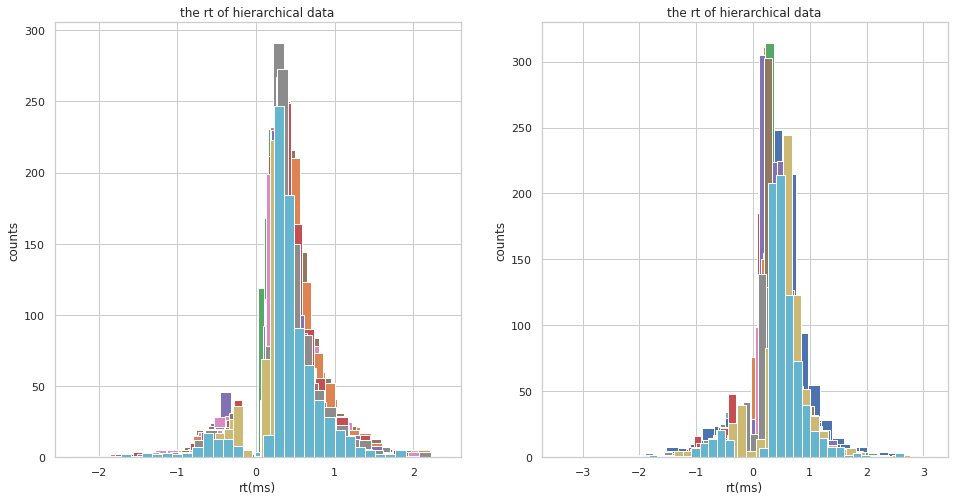

In [59]:
# create the figure 
f, ax = plt.subplots(1,2,figsize=(16, 8))

# the rt of hierarchical data
df.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[0])
# the labels of hierarchical data
ax[0].set_title('the rt of hierarchical data')
ax[0].set_xlabel('rt(ms)')
ax[0].set_ylabel('counts')

# the rt of non-hierarchical data
data.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[1])
# the labels of hierarchical data
ax[1].set_title('the rt of hierarchical data')
ax[1].set_xlabel('rt(ms)')
ax[1].set_ylabel('counts')

### rt distribution of different conditions

Text(0, 0.5, 'counts')

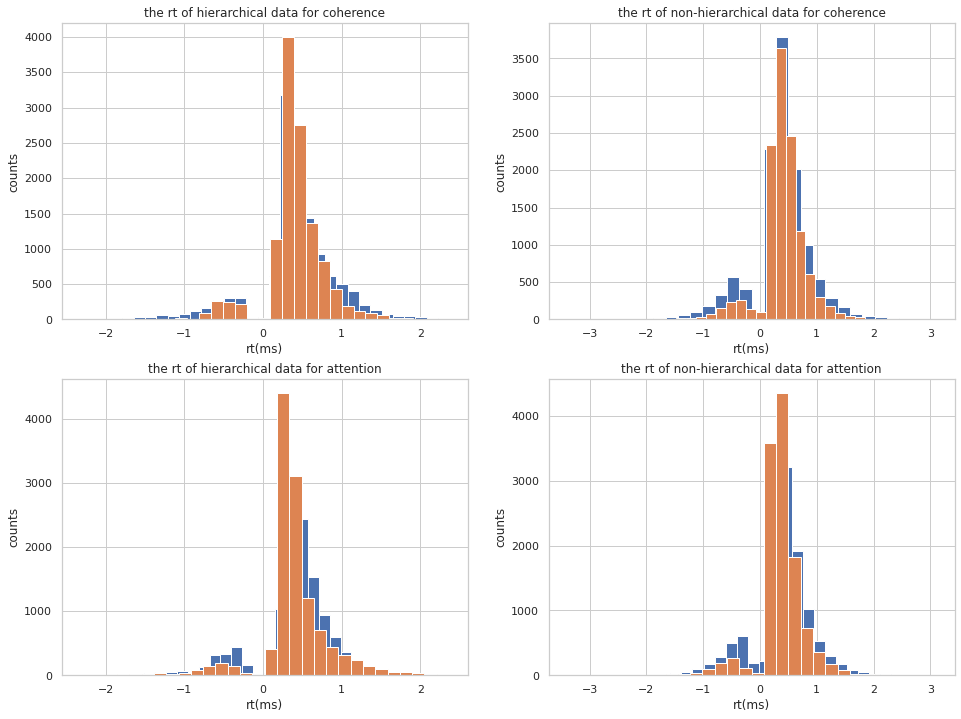

In [60]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
df.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of hierarchical data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')

# the rt of non-hierarchical data for coherence
data.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of non-hierarchical data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')

# the rt of hierarchical data for attention
df.groupby(['attention']).rt.hist(bins=30,ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of hierarchical data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')

# the rt of non-hierarchical data for attention
data.groupby(['attention']).rt.hist(bins=30,ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('the rt of non-hierarchical data for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')

### the parameter distributions

Text(0, 0.5, 'density')

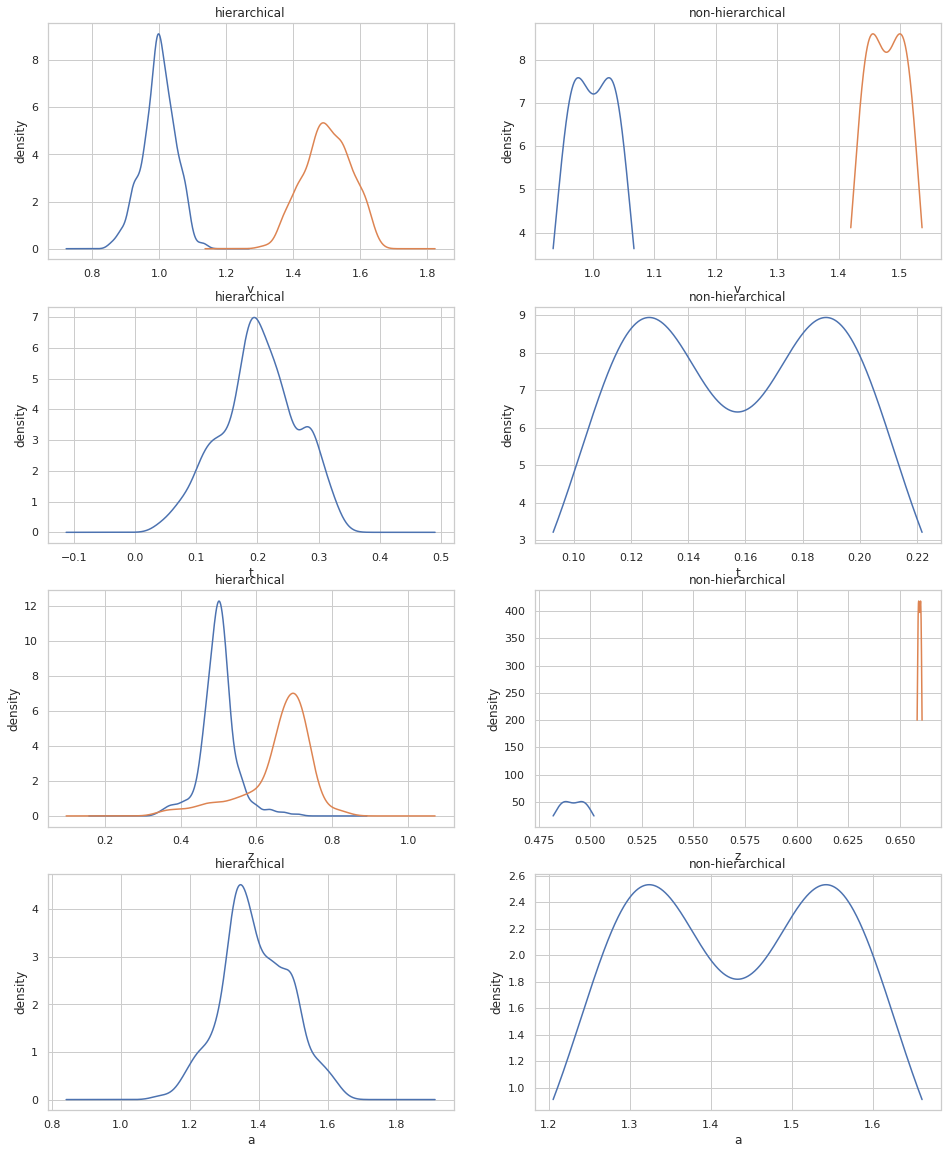

In [81]:
# create the figure 
f, ax = plt.subplots(4,2,figsize=(16, 20))

# the rt of hierarchical data for coherence
# v
params.groupby(['coherence']).v.plot.kde(ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('hierarchical')
ax[0,0].set_xlabel('v')
ax[0,0].set_ylabel('density')

# t
params.t.plot.kde(ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('hierarchical')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('density')

# z
params.groupby(['attention']).z.plot.kde(ax=ax[2,0])
# the labels of hierarchical data
ax[2,0].set_title('hierarchical')
ax[2,0].set_xlabel('z')
ax[2,0].set_ylabel('density')

# a
params.a.plot.kde(ax=ax[3,0])
# the labels of hierarchical data
ax[3,0].set_title('hierarchical')
ax[3,0].set_xlabel('a')
ax[3,0].set_ylabel('density')

# the rt of non-hierarchical data for coherence
# v
param.groupby(['coherence']).v.plot.kde(ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('non-hierarchical')
ax[0,1].set_xlabel('v')
ax[0,1].set_ylabel('density')

# t
param.t.plot.kde(ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('non-hierarchical')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('density')

# z
param.groupby(['attention']).z.plot.kde(ax=ax[2,1])
# the labels of hierarchical data
ax[2,1].set_title('non-hierarchical')
ax[2,1].set_xlabel('z')
ax[2,1].set_ylabel('density')

# a
param.a.plot.kde(ax=ax[3,1])
# the labels of hierarchical data
ax[3,1].set_title('non-hierarchical')
ax[3,1].set_xlabel('a')
ax[3,1].set_ylabel('density')

## linear regression

In previous part, when we set the population parameter of different condition, the stochastic subject parameter would be generated.

In this part, we want to check whether the we can contruct the linear regresiion and recover the grand param.



### model for v:

$v_{j}=\beta_{0,j} + \beta_{1,j}*C(coherence)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [82]:
# contrust model
m1 = bmb.Model("v ~ 1 + coherence + (1 + coherence|subj_idx)", data=params)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, coherence|subj_idx_offset, coherence|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, coherence, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 23 seconds.


In [83]:
m1

Formula: v ~ 1 + coherence + (1 + coherence|subj_idx)
Family name: Gaussian
Link: identity
Observations: 1200
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.2505, sigma: 0.9122)
    coherence ~ Normal(mu: 0.0, sigma: 1.2901)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.9122))
    coherence|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2901))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.258)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'coherence'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>],
      dtype=object)

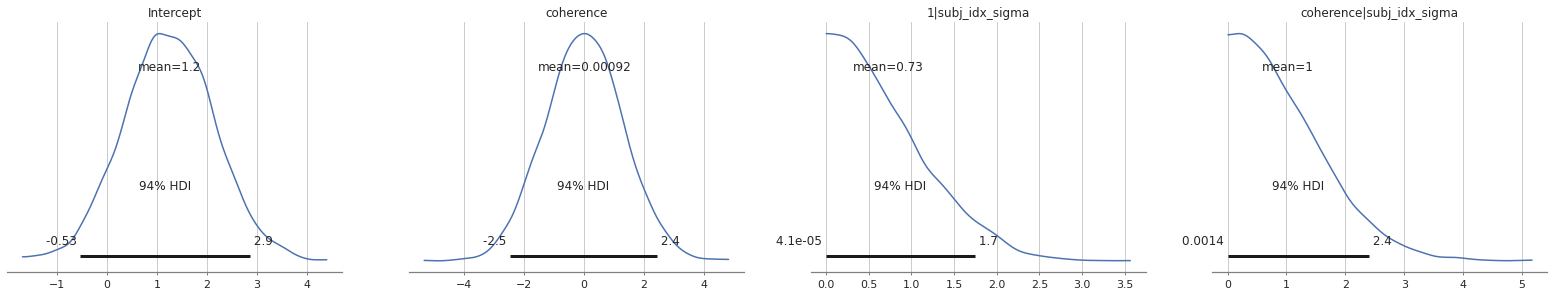

In [84]:
m1.plot_priors(var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'coherence'}>,
        <AxesSubplot:title={'center':'coherence'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>]],
      dtype=object)

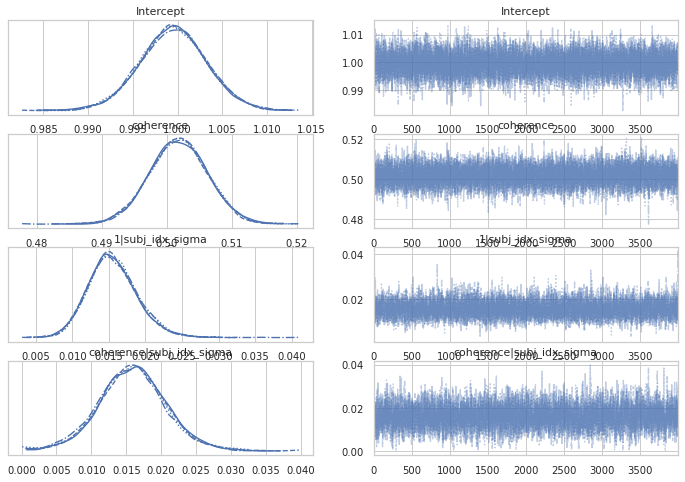

In [85]:
# Plot posteriors
az.plot_trace(
    res1,
    var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'],
    compact=True,
)

In [86]:
az.summary(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma','v_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.000,0.004,0.993,1.007,0.0,0.0,12053.0,10678.0,1.0
coherence,0.502,0.004,0.493,0.510,0.0,0.0,13263.0,11069.0,1.0
1|subj_idx_sigma,0.016,0.003,0.009,0.022,0.0,0.0,6918.0,9890.0,1.0
coherence|subj_idx_sigma,0.016,0.005,0.007,0.025,0.0,0.0,5165.0,5690.0,1.0
v_sigma,0.057,0.001,0.055,0.059,0.0,0.0,19357.0,11711.0,1.0


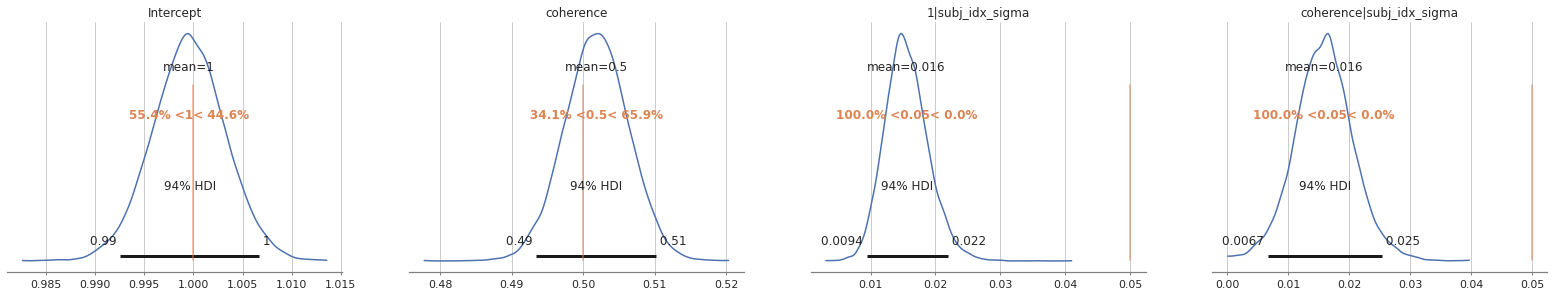

In [87]:
az.plot_posterior(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'], ref_val=[v_int,v_coh,v_sig1,v_sig2]);


### model for z:

$z_{j}=\beta_{0,j} + \beta_{1,j}*C(attention)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [88]:
# contrust model
m2 = bmb.Model("z ~ 1 + attention + (1 + attention|subj_idx)", data=params)
# model fit
res2 = m2.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_sigma, attention|subj_idx_offset, attention|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, attention, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 21 seconds.
There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7158846654615929, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [89]:
m2

Formula: z ~ 1 + attention + (1 + attention|subj_idx)
Family name: Gaussian
Link: identity
Observations: 1200
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.5792, sigma: 0.3765)
    attention ~ Normal(mu: 0.0, sigma: 0.5325)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.3765))
    attention|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.5325))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.1065)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'attention'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>],
      dtype=object)

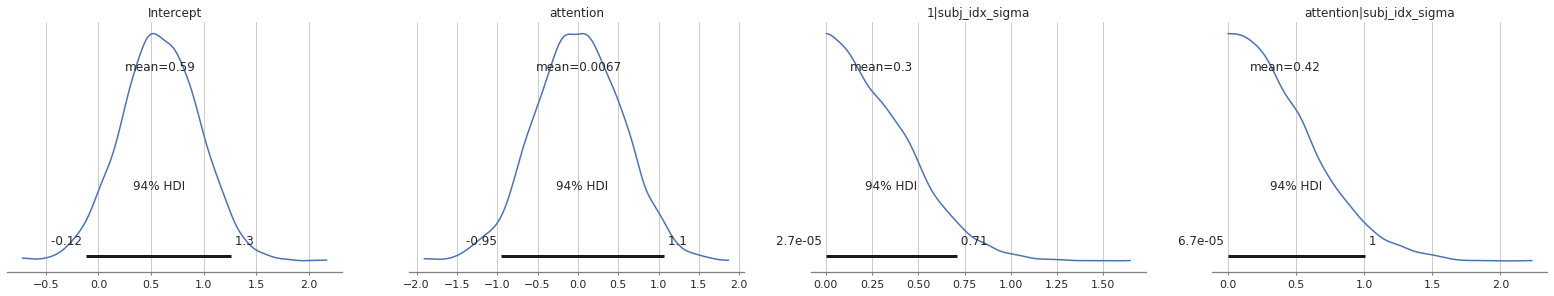

In [90]:
m2.plot_priors(var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'attention'}>,
        <AxesSubplot:title={'center':'attention'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'attention|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>]],
      dtype=object)

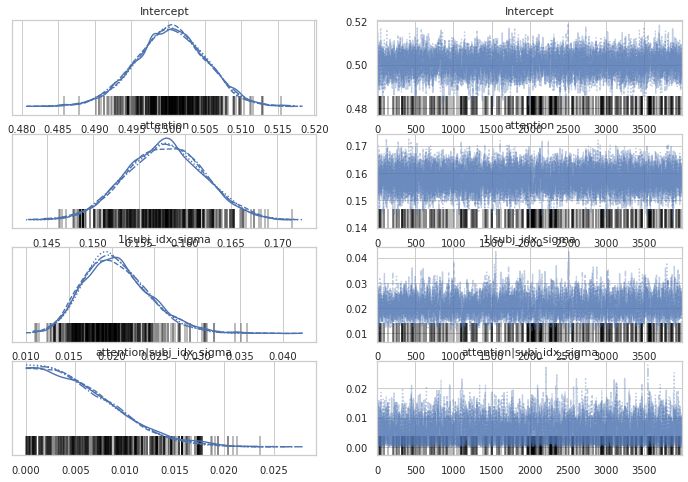

In [91]:
# Plot posteriors
az.plot_trace(
    res2,
    var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],
    compact=True,
)

In [92]:
az.summary(res2, var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma','z_sigma'],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.500,0.005,0.491,0.509,0.0,0.0,4013.0,5846.0,1.0
attention,0.158,0.004,0.150,0.166,0.0,0.0,7390.0,5842.0,1.0
1|subj_idx_sigma,0.021,0.004,0.014,0.028,0.0,0.0,2815.0,4535.0,1.0
attention|subj_idx_sigma,0.006,0.004,0.000,0.013,0.0,0.0,3002.0,2807.0,1.0
z_sigma,0.069,0.001,0.066,0.071,0.0,0.0,7899.0,6460.0,1.0


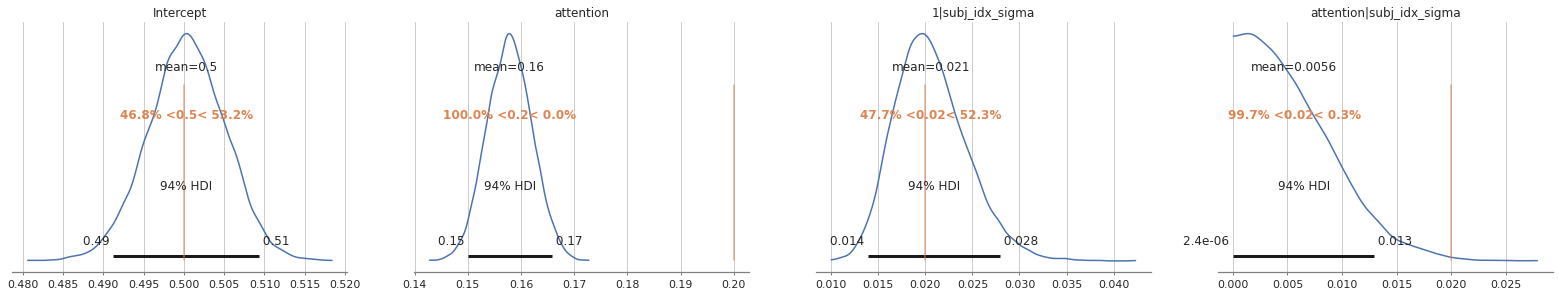

In [93]:
az.plot_posterior(res2,  var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'], ref_val=[z_int,z_pri,z_sig1,z_sig2]);
